# Grating coupler

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FGratingCoupler.ipynb).

In [1]:
# basic imports
import numpy as np
import matplotlib.pylab as plt

# tidy3d imports
import tidy3d as td
import tidy3d.web as web

Using Tidy3D credentials from stored file


## Problem Setup

In this example, we model a 3D grating coupler in a Silicon on Insulator (SOI) platform.

A basic schematic of the design is shown below.  The simulation is about 19um x 4um x 5um with a wavelength of 1.55um and takes about 1 minute to simulate 10,000 time steps.

In the simulation, we inject a modal source into the waveguide and propagate it towards the grating structure.  The radiation from the grating coupler is then measured with a near field monitor and we use a far field projection to inspect the angular dependence of the radiation.

<img src="img/grating_coupler.png" width=600>

In [2]:
# basic parameters (note, all length units are microns)
nm = 1e-3
wavelength = 1550 * nm

# resolution
grids_per_wavelength = 50.0
dl = wavelength / grids_per_wavelength

# waveguide
wg_width = 400 * nm
wg_height = 220 * nm
wg_length = 2 * wavelength

# surrounding
sub_height = 2.0
air_height = 2.0
buffer = 0.5 * wavelength

# coupler
cp_width = 4 * wavelength
cp_length = 8 * wavelength
taper_length = 6 * wavelength

In [3]:
# sizes
Lx = buffer + wg_length + taper_length + cp_length
Ly = buffer + cp_width + buffer
Lz = sub_height + wg_height + air_height
sim_size = [Lx, Ly, Lz]

# convenience variables to store center of coupler and waveguide
wg_center_x = +Lx/2 - buffer - (wg_length + taper_length)/2
cp_center_x = -Lx/2 + buffer + cp_length/2
wg_center_z = -Lz/2 + sub_height + wg_height/2
cp_center_z = -Lz/2 + sub_height + wg_height/2

# materials
Air = td.Medium(permittivity=1.0)
Si = td.Medium(permittivity=3.47**2)
SiO2 = td.Medium(permittivity=1.44**2)

# source parameters
freq0 = td.C_0 / wavelength
fwidth = freq0 / 10
run_time = 100 / fwidth

## Mode Solve
To determine the pitch of the waveguide for a given design angle, we need to compute the effective index of the waveguide mode being coupled into.  For this, we set up a simple simulation of the coupler region and use the mode solver to get the effective index. We will not run this simulation, we just add a ``ModeMonitor`` object in order to call the mode solver, ``sim.compute_modes()`` below, and get the effective index of the wide-waveguide region.

[11:59:35] WARNING  No sources in simulation.                               ]8;id=597944;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:361

<AxesSubplot:title={'center':'cross section at z=0.00'}, xlabel='x', ylabel='y'>

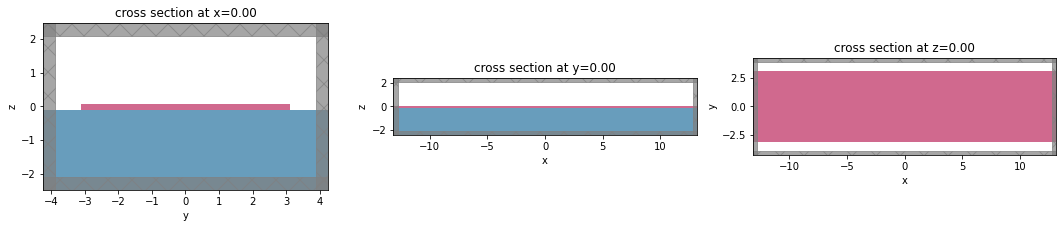

In [4]:
# grating parameters
design_theta_deg = -30
design_theta_rad = np.pi * design_theta_deg / 180
grating_height = 70 * nm

# do a mode solve to get neff of the coupler

sub = td.Structure(
    geometry=td.Box(
        center=[0, 0, -Lz/2],
        size=[td.inf, td.inf, 2 * sub_height]
    ),
    medium=SiO2,
    name='substrate')

cp = td.Structure(
    geometry=td.Box(
        center=[0, 0, cp_center_z-grating_height/4],
        size=[td.inf, cp_width, wg_height-grating_height/2]
    ),
    medium=Si,
    name='coupler')

mode_plane = td.Box(
    center=(0,0,0),
    size=(0, 8*cp_width, 8*wg_height)
)


sim = td.Simulation(
    size=sim_size,
    grid_size=[dl, dl, dl],
    structures=[sub, cp],
    sources=[],
    monitors=[],
    pml_layers=3*[td.PML()])

f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3))
sim.plot(x=0, ax=ax1)
sim.plot(y=0, ax=ax2)
sim.plot(z=0, ax=ax3)

## Compute Effective index for Grating Pitch Design

In [5]:
from tidy3d.plugins import ModeSolver
ms = ModeSolver(simulation=sim, plane=mode_plane, freq=freq0)
mode_output = ms.solve(td.ModeSpec())[0]

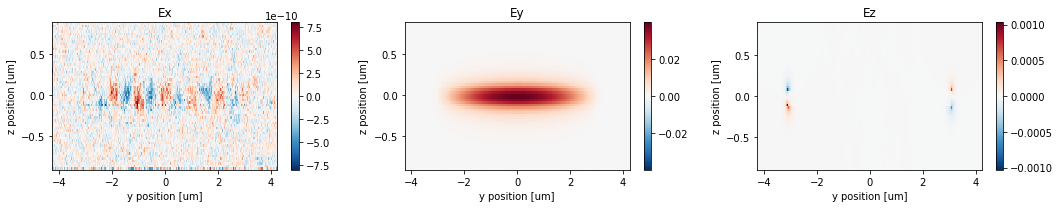

In [6]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3))
mode_output.field_data.Ex.real.plot(x='y', y='z', ax=ax1)
mode_output.field_data.Ey.real.plot(x='y', y='z', ax=ax2)
mode_output.field_data.Ez.real.plot(x='y', y='z', ax=ax3)
ax1.set_title('Ex')
ax2.set_title('Ey')
ax3.set_title('Ez')
plt.show()

In [7]:
neff = mode_output.n_eff
print(f'effective index = {neff:.4f}')

effective index = 2.6997


## Create Simulation
Now we set up the grating coupler to simulate in Tidy3D.

In [8]:
# gratings
pitch = wavelength / (neff - np.sin(abs(design_theta_rad)))
grating_length = pitch / 2.0
num_gratings = int(cp_length / pitch)

sub = td.Structure(
    geometry=td.Box(
        center=[0, 0, -Lz/2],
        size=[td.inf, td.inf, 2 * sub_height],
    ),
    medium=SiO2,
    name='substrate')

wg = td.Structure(
    geometry=td.Box(
        center=[wg_center_x, 0, wg_center_z],
        size=[buffer + wg_length + taper_length + cp_length/2, wg_width, wg_height],
    ),
    medium=Si,
    name='waveguide')

cp = td.Structure(
    geometry=td.Box(
        center=[cp_center_x, 0, cp_center_z],
        size=[cp_length, cp_width, wg_height],
    ),
    medium=Si,
    name='coupler')

tp = td.Structure(
    geometry=td.PolySlab(
    vertices=[
        [cp_center_x + cp_length/2 + taper_length, + wg_width/2],
        [cp_center_x + cp_length/2 + taper_length, - wg_width/2],
        [cp_center_x + cp_length/2, - cp_width/2],
        [cp_center_x + cp_length/2, + cp_width/2]],
        slab_bounds=(wg_center_z-wg_height/2, wg_center_z+wg_height/2),
        axis=2,
    ),
    medium=Si,
    name='taper')

grating_left_x = cp_center_x - cp_length/2
gratings = [
    td.Structure(
        geometry=td.Box(
            center=[grating_left_x + (i + 0.5) * pitch, 0, cp_center_z + wg_height/2 - grating_height/2],
            size=[grating_length, cp_width, grating_height],
        ),
        medium=Air,
        name=f'{i}th_grating')
    for i in range(num_gratings)]

In [9]:
# distance to near field monitor
nf_offset = 50 * nm

plane_monitor = td.FieldMonitor(
    center=[0, 0, cp_center_z],
    size=[td.inf, td.inf, 0],
    freqs=[freq0],
    name='full_domain_fields')

rad_monitor = td.FieldMonitor(
    center=[0, 0, 0],
    size=[td.inf, 0, td.inf],
    freqs=[freq0],
    name='radiated_fields')

near_field_monitor = td.FieldMonitor(
    center=[cp_center_x, 0, cp_center_z + wg_height/2 + nf_offset],
    size=[td.inf, td.inf, 0],
    freqs=[freq0],
    name='radiated_near_fields')

In [10]:
sim = td.Simulation(
    size=sim_size,
    grid_size=[dl, dl, dl],
    structures=[sub, wg, cp, tp] + gratings,
    sources=[],
    monitors=[plane_monitor, rad_monitor, near_field_monitor],
    run_time=run_time,
    pml_layers=3*[td.PML()])

[11:59:39] WARNING  No sources in simulation.                               ]8;id=775850;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:361

### Make Modal Source

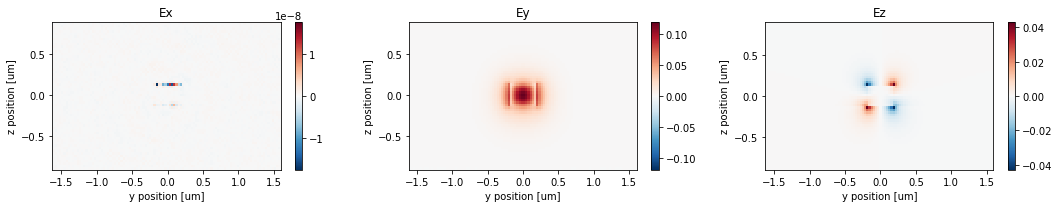

In [11]:
source_plane = td.Box(
    center=[Lx/2 - buffer, 0, cp_center_z],
    size=[0, 8*wg_width, 8*wg_height],
)

ms = ModeSolver(sim, source_plane, freq0)
mode_output = ms.solve(td.ModeSpec())[0]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3))
mode_output.field_data.Ex.real.plot(x='y', y='z', ax=ax1)
mode_output.field_data.Ey.real.plot(x='y', y='z', ax=ax2)
mode_output.field_data.Ez.real.plot(x='y', y='z', ax=ax3)
ax1.set_title('Ex')
ax2.set_title('Ey')
ax3.set_title('Ez')
plt.show()

In [12]:
mode_src = ms.to_source(mode_spec=td.ModeSpec(), mode_index=0, direction='-', fwidth=fwidth)
sim.sources.append(mode_src)

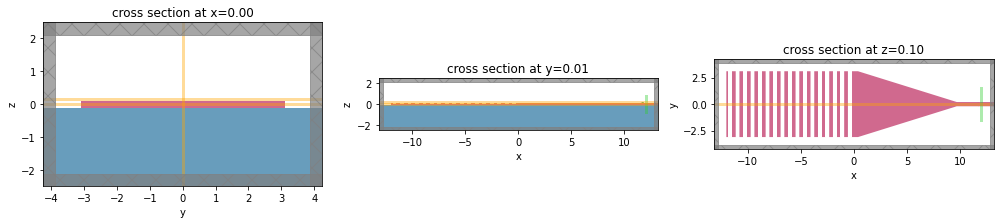

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(14, 3))
sim.plot(x=0, ax=ax1)
sim.plot(y=0.01, ax=ax2)
sim.plot(z=0.1, ax=ax3)
plt.show()

In [14]:
mode_src.help()

╭────────────────────── <class 'tidy3d.components.source.ModeSource'> ──────────────────────╮
│ Injects current source to excite modal profile on finite extent plane.                    │
│                                                                                           │
│ ╭───────────────────────────────────────────────────────────────────────────────────────╮ │
│ │ ModeSource(center=(12.012500000000001, 0.0, -3.191891195797325e-16),                  │ │
│ │ type='ModeSource', size=(0.0, 3.2, 1.76), source_time=GaussianPulse(amplitude=1.0,    │ │
│ │ phase=0.0, type='GaussianPulse', freq0=193414489407062.47, fwidth=19341448940706.246, │ │
│ │ offset=5.0), name=None, direction='-', mode_spec=ModeSpec(num_modes=1,                │ │
│ │ target_neff=None, num_pml=(0, 0), bend_radius=None, bend_axis=None, type='ModeSpec'), │ │
│ │ mode_index=0)                                                                         │ │
│ ╰───────────────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                           │
│ bounding_box = Box(center=(12.012500000000001, 0.0, -3.3306690738754696e-16), type='Box', │
│                size=(0.0, 3.2, 1.76))                                                     │
│       bounds = (                                                                          │
│                    (12.012500000000001, -1.6, -0.8800000000000003),                       │
│                    (12.012500000000001, 1.6, 0.8799999999999997)                          │
│                )                                                                          │
│       center = (12.012500000000001, 0.0, -3.191891195797325e-16)                          │
│    direction = '-'                                                                        │
│     geometry = Box(center=(12.012500000000001, 0.0, -3.191891195797325e-16), type='Box',  │
│                size=(0.0, 3.2, 1.76))                                                     │
│   mode_index = 0                                                                          │
│    mode_spec = ModeSpec(num_modes=1, target_neff=None, num_pml=(0, 0), bend_radius=None,  │
│                bend_axis=None, type='ModeSpec')                                           │
│         name = None                                                                       │
│         size = (0.0, 3.2, 1.76)                                                           │
│  source_time = GaussianPulse(amplitude=1.0, phase=0.0, type='GaussianPulse',              │
│                freq0=193414489407062.47, fwidth=19341448940706.246, offset=5.0)           │
│         type = 'ModeSource'                                                               │
╰───────────────────────────────────────────────────────────────────────────────────────────╯

## Run Simulation

Run the simulation and plot the field patterns

In [15]:
# create a project, upload to our server to run
job = web.Job(simulation=sim, task_name='grating_coupler')
sim_data = job.run(path='data/grating_coupler.hdf5')
print(sim_data.log)

Downloading... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

[12:01:38] INFO     loading SimulationData from data/grating_coupler.hdf5       ]8;id=291995;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:303

Simulation domain Nx, Ny, Nz: [849, 274, 160]
Applied symmetries: (0, 0, 0)
Number of computational grid points: 3.7220e+07.
Using subpixel averaging: True
Number of time steps: 9.6227e+04
Automatic shutoff factor: 1.00e-05
Time step (s): 5.3731e-17
Compute source modes time (s):     0.6852
Compute monitor modes time (s):    0.4255

Rest of setup time (s):            0.8577

Starting solver...
- Time step    766 / time 4.12e-14s (  0 % done), field decay: 1.00e+00
- Time step   3849 / time 2.07e-13s (  4 % done), field decay: 1.00e+00
- Time step   7698 / time 4.14e-13s (  8 % done), field decay: 2.46e-02
- Time step  11547 / time 6.20e-13s ( 12 % done), field decay: 6.67e-03
- Time step  15396 / time 8.27e-13s ( 16 % done), field decay: 4.07e-04
- Time step  19245 / time 1.03e-12s ( 20 % done), field decay: 7.95e-05
- Time step  23094 / time 1.24e-12s ( 24 % done), field decay: 2.39e-05
- Time step  26943 / time 1.45e-12s ( 28 % done), field decay: 6.59e-06
Field decay smaller than sh

<AxesSubplot:title={'center':'f = 193414489407062.47, y = 0'}, xlabel='x position [um]', ylabel='z position [um]'>

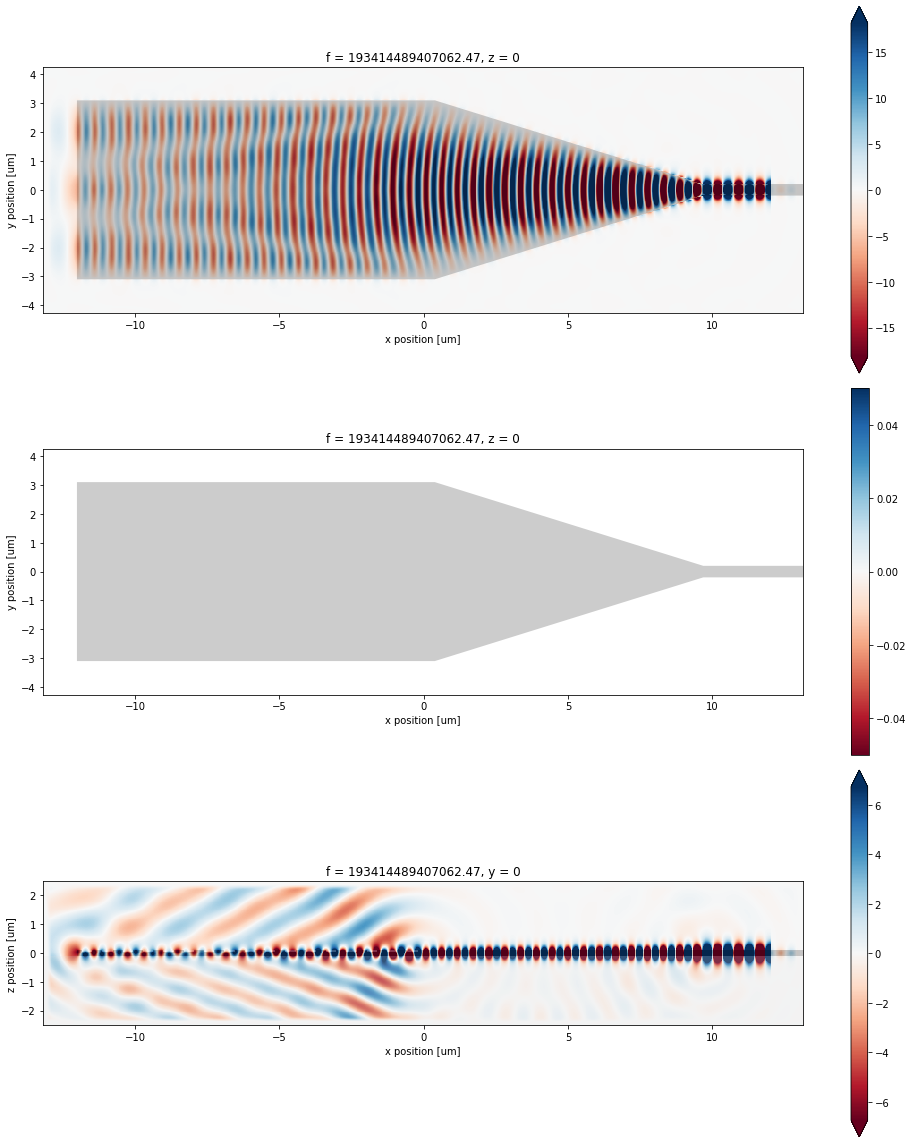

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, tight_layout=True, figsize=(14, 16))
sim_data.plot_field('full_domain_fields', 'Ey', freq=freq0, z=0, ax=ax1)
sim_data.plot_field('radiated_near_fields', 'Ey', freq=freq0, z=0, ax=ax2)
sim_data.plot_field('radiated_fields', 'Ey', freq=freq0, y=0, ax=ax3)

## Far Field Projection
Now we use the Near2Far feature of Tidy3D to compute the anglular dependence of the far field scattering based on the near field monitor.

In [17]:
from tidy3d.plugins import Near2Far, Near2FarSurface
from rich.progress import track  # use for progressbar while doing transformation

In [18]:
# create range of angles to probe (note: polar coordinates, theta = 0 corresponds to vertical (z axis))
num_angles = 1101
thetas = np.linspace(-np.pi/2, np.pi/2, num_angles)

# make a near field to far field projector with the near field monitor data

near_field_surface = Near2FarSurface(monitor=near_field_monitor, normal_dir="+")
n2f = Near2Far(sim_data=sim_data, surfaces=[near_field_surface], frequency=freq0)

# loop through angles and record the scattered cross section
Ps = np.zeros(num_angles)
for i in track(range(num_angles), description='performing far field transformtion...'):
    Ps[i] = n2f.radar_cross_section(thetas[i], 0.0)

performing far field transformtion... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

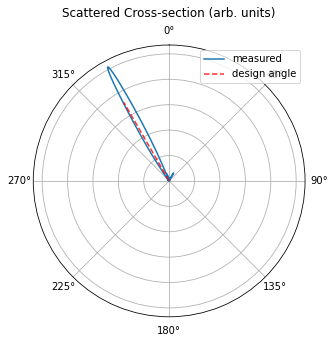

In [19]:
# plot the angle dependence
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(5,5))
ax.plot(thetas, Ps, label='measured')
ax.plot([design_theta_rad, design_theta_rad], [0, np.max(Ps)*0.7], 'r--', alpha=0.8, label='design angle')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_yticklabels([])
ax.set_title("Scattered Cross-section (arb. units)", va='bottom')
plt.legend()
plt.show()

In [20]:
print(f'expect angle of {(design_theta_rad * 180 / np.pi):.2f} degrees')
i_max = np.argmax(Ps)
print(f'got maximum angle of {(thetas[i_max] * 180 / np.pi):.2f} degrees')

expect angle of -30.00 degrees
got maximum angle of -28.31 degrees


The agreement between the target angle and the actual emission angle of the coupler is very good. The small difference comes from the fact that the design is very sensitive to the value of the effective index that we use in the coupler region, and that value depends on which waveguide height we pick in that region: the one with the grating comb, or without. In our setup, we used a thickness that is at the mid-point, but this is a heuristic choice which results in the small final mismatch in angles observed here.

## Gaussian beam into the coupler

We can also run the coupler in the opposite way, injecting a Gaussian beam from above and monitoring the transmission into the waveguide.

In [21]:
gaussian_beam = td.GaussianBeam(
    size=(td.inf, td.inf, 0),
    center=[-8, 0, 2],
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    angle_theta=np.pi/6,
    angle_phi=np.pi,
    direction='-',
    waist_radius=2,
    pol_angle=np.pi/2)

mode_mon = ms.to_monitor(freqs=[freq0], mode_spec=td.ModeSpec(), name='coupled')

flux_mon = td.FluxMonitor(
    size=mode_mon.size,
    center=mode_mon.center,
    freqs=[freq0],
    name='flux',
)


sim2 = td.Simulation(
    size=sim_size,
    grid_size=[dl, dl, dl],
    structures=[sub, wg, cp, tp] + gratings,
    sources=[gaussian_beam],
    monitors=[plane_monitor, rad_monitor, mode_mon, flux_mon],
    run_time=run_time,
    pml_layers=3*[td.PML()])

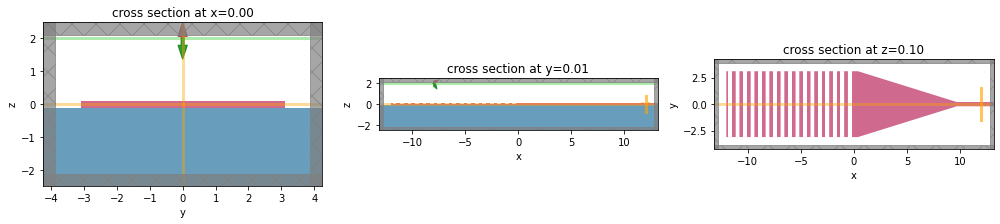

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(14, 3))
sim2.plot(x=0, ax=ax1)
sim2.plot(y=0.01, ax=ax2)
sim2.plot(z=0.1, ax=ax3)
plt.show()

In [23]:
job2 = web.Job(simulation=sim2, task_name='grating_coupler_beam')
sim_data2 = job2.run(path='data/grating_coupler.hdf5')
print(sim_data2.log)

Downloading... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

[12:03:30] INFO     loading SimulationData from data/grating_coupler.hdf5       ]8;id=39180;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:303

Simulation domain Nx, Ny, Nz: [849, 274, 160]
Applied symmetries: (0, 0, 0)
Number of computational grid points: 3.7220e+07.
Using subpixel averaging: True
Number of time steps: 9.6227e+04
Automatic shutoff factor: 1.00e-05
Time step (s): 5.3731e-17
Compute source modes time (s):     0.4245
Compute monitor modes time (s):    0.6978

Rest of setup time (s):            2.1725

Starting solver...
- Time step    766 / time 4.12e-14s (  0 % done), field decay: 1.00e+00
- Time step   3849 / time 2.07e-13s (  4 % done), field decay: 1.00e-02
- Time step   7698 / time 4.14e-13s (  8 % done), field decay: 1.67e-03
- Time step  11547 / time 6.20e-13s ( 12 % done), field decay: 3.33e-05
- Time step  15396 / time 8.27e-13s ( 16 % done), field decay: 6.12e-06
Field decay smaller than shutoff factor, exiting solver.

Solver time (s):                   25.0283
Post-processing time (s):          0.5103



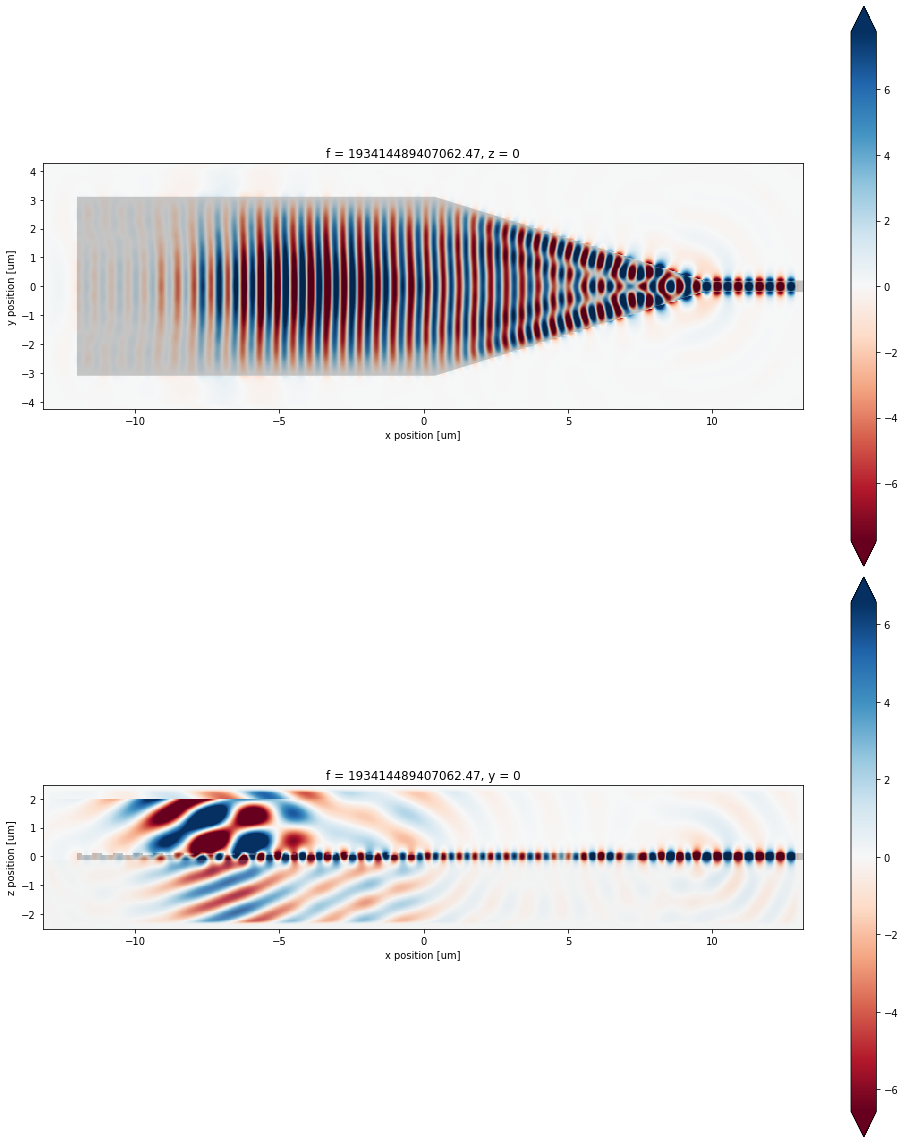

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, tight_layout=True, figsize=(14, 16))
sim_data2.plot_field('full_domain_fields', 'Ey', freq=freq0, z=0, ax=ax1)
sim_data2.plot_field('radiated_fields', 'Ey', freq=freq0, y=0, ax=ax2)
plt.show()

In [25]:
flux = sim_data2['flux']
print(f'flux in waveguide / flux in = {float(flux.values):.2f} ')

flux in waveguide / flux in = 0.05 


The coupler has 5% in-coupling efficiency, and we did not put any effort into optimizing it beyond just defining the grating pitch to target the correct angle!